<a href="https://colab.research.google.com/github/alaki22/Facial-Expression-Recognition-Challenge/blob/main/loading_kaggle_data_to_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/yEXkEUqK52Q

**Downloading Kaggle data sets directly into Colab**

Install the kaggle python library

In [2]:
! pip install kaggle

Mount the Google drive so you can store your kaggle API credentials for future use

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Make a directory for kaggle at the temporary instance location on Colab drive.

Download your kaggle API key (.json file). You can do this by going to your kaggle account page and clicking 'Create new API token' under the API section.

In [4]:
! mkdir ~/.kaggle

If you want to copy the kaggle API credentials to the temporary location... (I recommend placing it on your Google Drive)

In [5]:
#! cp kaggle.json ~/.kaggle/

Upload the json file to Google Drive and then copy to the temporary location.

In [6]:
!cp /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json ~/.kaggle/kaggle.json

Change the file permissions to read/write to the owner only

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

**Competitions and Datasets are the two types of Kaggle data**

**1. Download competition data**

If you get 403 Forbidden error, you need to click 'Late Submission' on the Kaggle page for that competition.

In [8]:
! kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

 87% 248M/285M [00:00<00:00, 744MB/s] 
100% 285M/285M [00:00<00:00, 788MB/s]


Unzip, in case the downloaded file is zipped. Refresh the files on the left hand side to update the view.

In [14]:
! unzip challenges-in-representation-learning-facial-expression-recognition-challenge

Archive:  challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [9]:
!pip install -q wandb

import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: alaki22 (alaki22-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
import os

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
df = pd.read_csv('icml_face_data.csv')

In [17]:
X_val = df[df[' Usage'] == 'PrivateTest'].copy()
X_train = df[df[' Usage'] == 'Training'].copy()
X_test = df[df[' Usage'] == 'PublicTest'].copy()
print(f"Actual Training set size: {len(X_train)}")
print(f"Actual Validation set size: {len(X_val)}")
print(f"Actual Public Test set size: {len(X_test)}")

Actual Training set size: 28709
Actual Validation set size: 3589
Actual Public Test set size: 3589


In [18]:
df_training_only = df[df[' Usage'] == 'Training'].copy()

In [19]:
subset_size = 20
df_subset = df_training_only.head(subset_size)

In [20]:
df_subset.head(subset_size)

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,Training,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,Training,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,Training,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,Training,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,Training,255 254 255 254 254 179 122 107 95 124 149 150...


In [42]:
df_train_subset, df_val_subset = train_test_split(
    df_subset,
    test_size=0.2,
    random_state=42)

In [22]:
print(f"Training subset size: {len(df_train_subset)}")
print(f"Validation subset size: {len(df_val_subset)}")

Training subset size: 16
Validation subset size: 4


In [24]:
class EmotionRecognitionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.pixels = df[' pixels'].apply(lambda x: np.array(x.split(' '), dtype='float32').reshape(48, 48)).tolist()
        print(f"len(self.pixels): {len(self.pixels)}")
        self.emotions = df['emotion'].tolist()
        self.transform = transform

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, idx):
        image = self.pixels[idx]
        emotion = self.emotions[idx]

        image = image / 255.0
        image = torch.from_numpy(image).float().unsqueeze(0)

        if self.transform:
            image = self.transform(image)

        emotion = torch.tensor(emotion, dtype=torch.long)
        return image, emotion

In [43]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [44]:
train_dataset_subset = EmotionRecognitionDataset(df_train_subset, transform=transform)
val_dataset_subset = EmotionRecognitionDataset(df_val_subset, transform=transform)

len(self.pixels): 16
len(self.pixels): 4


In [45]:
batch_size = 4
train_loader_subset = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True)
val_loader_subset = DataLoader(val_dataset_subset, batch_size=batch_size, shuffle=False)


Verifying data loading (subset) with corrected normalization:
Batch images shape: torch.Size([4, 1, 48, 48])
Batch labels shape: torch.Size([4])


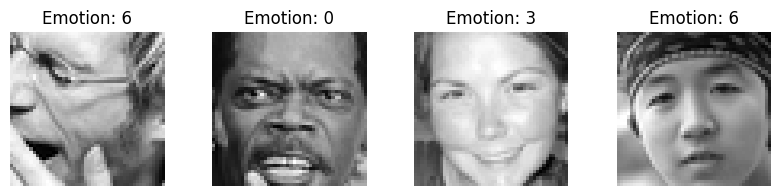

In [28]:
print("\nVerifying data loading (subset) with corrected normalization:")
for images, labels in train_loader_subset:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")

    plt.figure(figsize=(10, 2))
    for i in range(min(4, images.shape[0])):
        plt.subplot(1, 4, i+1)
        img_display = images[i].squeeze().numpy() * 0.5 + 0.5
        plt.imshow(img_display, cmap='gray')
        plt.title(f"Emotion: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

In [29]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_input_features = 64 * (48 // 4) * (48 // 4)
        self.fc1 = nn.Linear(self.fc1_input_features, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, self.fc1_input_features)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [46]:
model_cnn = SimpleCNN(num_classes=7).to(device)

criterion = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

In [31]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"\n--- Training {model.__class__.__name__} on subset ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)


        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        if num_epochs <= 20:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [47]:
history_cnn = train_model(model_cnn, train_loader_subset, val_loader_subset, criterion, optimizer_cnn, num_epochs=20)
train_losses_cnn, val_losses_cnn, train_accuracies_cnn, val_accuracies_cnn = history_cnn


--- Training SimpleCNN on subset ---
Epoch [1/20], Train Loss: 2.0844, Train Acc: 0.1250, Val Loss: 2.2829, Val Acc: 0.0000
Epoch [2/20], Train Loss: 1.4909, Train Acc: 0.3750, Val Loss: 2.6323, Val Acc: 0.0000
Epoch [3/20], Train Loss: 1.5322, Train Acc: 0.4375, Val Loss: 2.4929, Val Acc: 0.0000
Epoch [4/20], Train Loss: 1.1697, Train Acc: 0.7500, Val Loss: 2.4876, Val Acc: 0.0000
Epoch [5/20], Train Loss: 1.1068, Train Acc: 0.5625, Val Loss: 2.6588, Val Acc: 0.0000
Epoch [6/20], Train Loss: 0.8162, Train Acc: 0.6875, Val Loss: 2.9283, Val Acc: 0.0000
Epoch [7/20], Train Loss: 0.6880, Train Acc: 0.7500, Val Loss: 2.9225, Val Acc: 0.0000
Epoch [8/20], Train Loss: 0.4188, Train Acc: 0.9375, Val Loss: 2.9520, Val Acc: 0.0000
Epoch [9/20], Train Loss: 0.3011, Train Acc: 1.0000, Val Loss: 3.4793, Val Acc: 0.0000
Epoch [10/20], Train Loss: 0.4335, Train Acc: 0.8125, Val Loss: 3.9140, Val Acc: 0.0000
Epoch [11/20], Train Loss: 0.3434, Train Acc: 0.9375, Val Loss: 3.8037, Val Acc: 0.0000
Epo

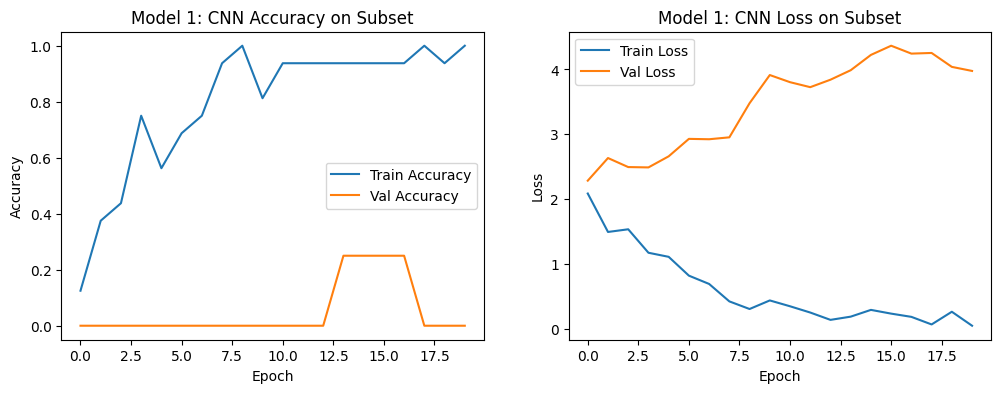

In [48]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_cnn, label='Train Accuracy')
plt.plot(val_accuracies_cnn, label='Val Accuracy')
plt.title('Model 1: CNN Accuracy on Subset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_cnn, label='Train Loss')
plt.plot(val_losses_cnn, label='Val Loss')
plt.title('Model 1: CNN Loss on Subset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
model_cnn.eval()
all_preds_cnn = []
all_labels_cnn = []
with torch.no_grad():
    for images, labels in val_loader_subset:
        images, labels = images.to(device), labels.to(device)
        outputs = model_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_cnn.extend(predicted.cpu().numpy().tolist())
        all_labels_cnn.extend(labels.cpu().numpy().tolist())


final_val_accuracy_cnn = accuracy_score(all_labels_cnn, all_preds_cnn)
print(f"Model 1 (CNN) - Final Validation Accuracy on subset: {final_val_accuracy_cnn:.4f}")
print(f"True labels (Val subset): {all_labels_cnn}")
print(f"Predicted labels (Val subset): {all_preds_cnn}")

Model 1 (CNN) - Final Validation Accuracy on subset: 0.0000
True labels (Val subset): [0, 2, 5, 0]
Predicted labels (Val subset): [2, 4, 2, 2]


In [50]:
class DeeperCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1_input_features = 128 * (48 // 8) * (48 // 8)
        self.fc1 = nn.Linear(self.fc1_input_features, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = self.pool3(torch.relu(self.conv3(x)))
        x = x.view(-1, self.fc1_input_features)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
model_deeper_cnn = DeeperCNN(num_classes=7).to(device)
optimizer_deeper_cnn = optim.Adam(model_deeper_cnn.parameters(), lr=0.001)

history_deeper_cnn = train_model(model_deeper_cnn, train_loader_subset, val_loader_subset, criterion, optimizer_deeper_cnn, num_epochs=20)
train_losses_deeper_cnn, val_losses_deeper_cnn, train_accuracies_deeper_cnn, val_accuracies_deeper_cnn = history_deeper_cnn


--- Training DeeperCNN on subset ---
Epoch [1/20], Train Loss: 1.9775, Train Acc: 0.1250, Val Loss: 2.1259, Val Acc: 0.0000
Epoch [2/20], Train Loss: 1.7433, Train Acc: 0.2500, Val Loss: 2.6033, Val Acc: 0.0000
Epoch [3/20], Train Loss: 1.5266, Train Acc: 0.1875, Val Loss: 3.2121, Val Acc: 0.0000
Epoch [4/20], Train Loss: 1.6378, Train Acc: 0.4375, Val Loss: 2.8646, Val Acc: 0.0000
Epoch [5/20], Train Loss: 1.5450, Train Acc: 0.2500, Val Loss: 2.1491, Val Acc: 0.2500
Epoch [6/20], Train Loss: 1.3940, Train Acc: 0.6875, Val Loss: 2.3895, Val Acc: 0.2500
Epoch [7/20], Train Loss: 1.0932, Train Acc: 0.6875, Val Loss: 3.4451, Val Acc: 0.0000
Epoch [8/20], Train Loss: 1.1896, Train Acc: 0.6250, Val Loss: 3.3731, Val Acc: 0.0000
Epoch [9/20], Train Loss: 0.7554, Train Acc: 0.6875, Val Loss: 2.5796, Val Acc: 0.0000
Epoch [10/20], Train Loss: 0.7520, Train Acc: 0.8750, Val Loss: 2.7047, Val Acc: 0.0000
Epoch [11/20], Train Loss: 0.6081, Train Acc: 0.8125, Val Loss: 2.9152, Val Acc: 0.0000
Epo

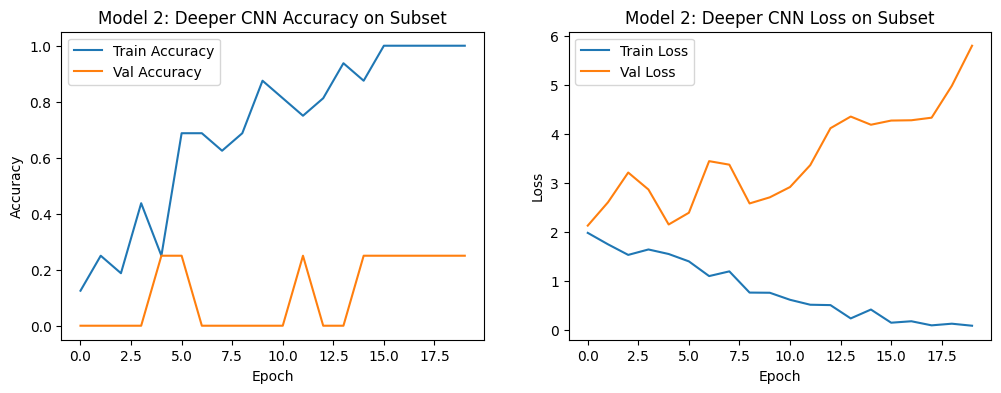

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_deeper_cnn, label='Train Accuracy')
plt.plot(val_accuracies_deeper_cnn, label='Val Accuracy')
plt.title('Model 2: Deeper CNN Accuracy on Subset')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses_deeper_cnn, label='Train Loss')
plt.plot(val_losses_deeper_cnn, label='Val Loss')
plt.title('Model 2: Deeper CNN Loss on Subset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [35]:
model_deeper_cnn.eval()
all_preds_deeper_cnn = []
all_labels_deeper_cnn = []
with torch.no_grad():
    for images, labels in val_loader_subset:
        images, labels = images.to(device), labels.to(device)
        outputs = model_deeper_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds_deeper_cnn.extend(predicted.cpu().numpy().tolist())
        all_labels_deeper_cnn.extend(labels.cpu().numpy().tolist())

final_val_accuracy_deeper_cnn = accuracy_score(all_labels_deeper_cnn, all_preds_deeper_cnn)
print(f"Model 2 (Deeper CNN) - Final Validation Accuracy on subset: {final_val_accuracy_deeper_cnn:.4f}")
print(f"True labels (Val subset): {all_labels_deeper_cnn}")
print(f"Predicted labels (Val subset): {all_preds_deeper_cnn}")

Model 2 (Deeper CNN) - Final Validation Accuracy on subset: 0.2500
True labels (Val subset): [0, 2, 5, 0]
Predicted labels (Val subset): [3, 6, 3, 0]


In [52]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_test_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [53]:
# subset_size_for_train = 1000
# subset_size_for_val = 700
train_dataset = EmotionRecognitionDataset(X_train, transform=train_transform)
val_dataset = EmotionRecognitionDataset(X_val, transform=val_test_transform)
test_dataset = EmotionRecognitionDataset(X_test, transform=val_test_transform)

len(self.pixels): 28709
len(self.pixels): 3589
len(self.pixels): 3589


In [54]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


Verifying data loading (full dataset batch):
Batch images shape: torch.Size([64, 1, 48, 48])
Batch labels shape: torch.Size([64])


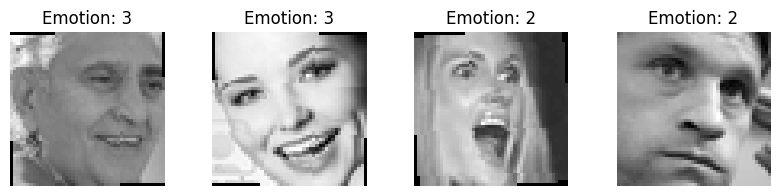

In [49]:
print("\nVerifying data loading (full dataset batch):")
for images, labels in train_loader:
    print(f"Batch images shape: {images.shape}")
    print(f"Batch labels shape: {labels.shape}")
    plt.figure(figsize=(10, 2))
    for i in range(min(4, images.shape[0])):
        plt.subplot(1, 4, i+1)
        img_display = images[i].squeeze().cpu().numpy() * 0.5 + 0.5
        plt.imshow(img_display, cmap='gray')
        plt.title(f"Emotion: {labels[i].item()}")
        plt.axis('off')
    plt.show()
    break

In [55]:
class EmotionVGG(nn.Module):
    def __init__(self, num_classes=7):
        super(EmotionVGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc1_input_features = 256 * 12 * 12

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.fc1_input_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [56]:
def train_model_optimized(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs,
                          early_stopping_patience, min_delta, model_save_path='best_emotion_model.pth'):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"\n--- Training {model.__class__.__name__} on FULL dataset ---")
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_accuracy = correct_train / total_train
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_accuracy = correct_val / total_val
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}')

        scheduler.step(epoch_val_loss)

        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
            print(f" --> Model saved: Best validation loss improved to {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f" --> Validation loss did not improve. Epochs no improve: {epochs_no_improve}")

        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered after {epochs_no_improve} epochs without improvement.")
            break

    print("Training complete.")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [57]:
class CNN_GlobalAveragePooling(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_GlobalAveragePooling, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [58]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(residual)
        out = self.relu(out)
        return out

class BasicResidualCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(BasicResidualCNN, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.layer1 = self._make_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self._make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(ResidualBlock, 256, 2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool1(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)

        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [59]:
models_to_train = {
    "SimpleCNN": SimpleCNN(),
    "DeeperCNN": DeeperCNN(),
    "EmotionVGG": EmotionVGG(),
    "CNN_GlobalAveragePooling": CNN_GlobalAveragePooling(),
    "BasicResidualCNN": BasicResidualCNN()
}

learning_rate = 0.001
fixed_batch_size = 64
fixed_optimizer_name = 'Adam'
fixed_dropout = 0.5
fixed_scheduler_patience = 7
fixed_weight_decay = 1e-4

num_epochs = 50
early_stopping_patience = 10
min_delta = 0.0001
results = {}

In [65]:
for model_name, model_instance in models_to_train.items():
    with wandb.init(project="FER2013_Individual_Models",
                    name=f"Training_{model_name}",
                    config={
                        "model_architecture": model_name,
                        "learning_rate": learning_rate,
                        "batch_size": fixed_batch_size,
                        "optimizer": fixed_optimizer_name,
                        "dropout": fixed_dropout,
                        "scheduler_patience": fixed_scheduler_patience,
                        "weight_decay": fixed_weight_decay,
                        "num_epochs": num_epochs,
                        "early_stopping_patience": early_stopping_patience,
                        "min_delta": min_delta
                    },
                    reinit=True) as run:

        print(f"\n===== Training {model_name} =====")
        current_model = model_instance.to(device)

        if fixed_optimizer_name == 'Adam':
            current_optimizer = optim.Adam(current_model.parameters(), lr=learning_rate, weight_decay=fixed_weight_decay)
        elif fixed_optimizer_name == 'SGD':
            current_optimizer = optim.SGD(current_model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=fixed_weight_decay)
        else:
            raise ValueError(f"Unsupported optimizer: {fixed_optimizer_name}")

        current_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            current_optimizer, mode='min', factor=0.5, patience=fixed_scheduler_patience, verbose=False
        )

        current_model_save_path = f'best_{model_name.lower()}.pth'

        history = train_model_optimized(
            current_model,
            train_loader,
            val_loader,
            criterion,
            current_optimizer,
            current_scheduler,
            num_epochs,
            early_stopping_patience,
            min_delta,
            current_model_save_path
        )
        train_losses, val_losses, train_accuracies, val_accuracies = history

        for epoch_idx in range(len(train_accuracies)):
            wandb.log({
                "epoch": epoch_idx + 1,
                "train_loss": train_losses[epoch_idx],
                "val_loss": val_losses[epoch_idx],
                "train_accuracy": train_accuracies[epoch_idx],
                "val_accuracy": val_accuracies[epoch_idx]
            })

        fig_curves, axes_curves = plt.subplots(1, 2, figsize=(12, 4))
        axes_curves[0].plot(train_accuracies, label='Train Accuracy')
        axes_curves[0].plot(val_accuracies, label='Val Accuracy')
        axes_curves[0].set_title(f'{model_name} - Accuracy')
        axes_curves[0].set_xlabel('Epoch')
        axes_curves[0].set_ylabel('Accuracy')
        axes_curves[0].legend()

        axes_curves[1].plot(train_losses, label='Train Loss')
        axes_curves[1].plot(val_losses, label='Val Loss')
        axes_curves[1].set_title(f'{model_name} - Loss')
        axes_curves[1].set_xlabel('Epoch')
        axes_curves[1].set_ylabel('Loss')
        axes_curves[1].legend()
        plt.tight_layout()
        wandb.log({"training_validation_curves": wandb.Image(fig_curves)})
        plt.close(fig_curves)

        current_model.load_state_dict(torch.load(current_model_save_path))
        current_model.eval()

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = current_model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

        final_val_accuracy = accuracy_score(all_labels, all_preds)

        results[model_name] = {
            'train_history': history,
            'final_val_accuracy': final_val_accuracy,
        }

        print(f"\n--- Evaluation for {model_name} on Validation Set (Best Model) ---")
        print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

        wandb.log({
            "final_validation_accuracy": final_val_accuracy
        })


        if os.path.exists(current_model_save_path):
            artifact = wandb.Artifact(name=f"{model_name}_best_model", type="model")
            artifact.add_file(current_model_save_path)
            run.log_artifact(artifact)
        else:
            print(f"Warning: Model checkpoint '{current_model_save_path}' not found. Cannot log as artifact.")

print("\n===== All Models Training Complete =====")
print("\n--- Summary of Model Performance ---")
for model_name, data in results.items():
    print(f"\nModel: {model_name}")
    print(f"  Final Validation Accuracy: {data['final_val_accuracy']:.4f}")


===== Training SimpleCNN =====

--- Training SimpleCNN on FULL dataset ---
Epoch [1/50], Train Loss: 1.5778, Train Acc: 0.3813, Val Loss: 1.4485, Val Acc: 0.4480
 --> Model saved: Best validation loss improved to 1.4485
Epoch [2/50], Train Loss: 1.4700, Train Acc: 0.4322, Val Loss: 1.3812, Val Acc: 0.4765
 --> Model saved: Best validation loss improved to 1.3812
Epoch [3/50], Train Loss: 1.4116, Train Acc: 0.4589, Val Loss: 1.3117, Val Acc: 0.5052
 --> Model saved: Best validation loss improved to 1.3117
Epoch [4/50], Train Loss: 1.3648, Train Acc: 0.4756, Val Loss: 1.2998, Val Acc: 0.5007
 --> Model saved: Best validation loss improved to 1.2998
Epoch [5/50], Train Loss: 1.3369, Train Acc: 0.4880, Val Loss: 1.2756, Val Acc: 0.5065
 --> Model saved: Best validation loss improved to 1.2756
Epoch [6/50], Train Loss: 1.3131, Train Acc: 0.4999, Val Loss: 1.2609, Val Acc: 0.5102
 --> Model saved: Best validation loss improved to 1.2609
Epoch [7/50], Train Loss: 1.2949, Train Acc: 0.5064, V

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
final_validation_accuracy,▁
train_accuracy,▁▂▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▇▆▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▄▃▄▄▅▅▅▅▆▆▆▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████
val_loss,█▇▅▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▁▁▁▁▁
epoch,50
final_validation_accuracy,0.59543
train_accuracy,0.62162
train_loss,0.9914
val_accuracy,0.59933



===== Training DeeperCNN =====

--- Training DeeperCNN on FULL dataset ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 1.6612, Train Acc: 0.3376, Val Loss: 1.4868, Val Acc: 0.4316
 --> Model saved: Best validation loss improved to 1.4868
Epoch [2/50], Train Loss: 1.4530, Train Acc: 0.4397, Val Loss: 1.3500, Val Acc: 0.4806
 --> Model saved: Best validation loss improved to 1.3500
Epoch [3/50], Train Loss: 1.3597, Train Acc: 0.4804, Val Loss: 1.2848, Val Acc: 0.5071
 --> Model saved: Best validation loss improved to 1.2848
Epoch [4/50], Train Loss: 1.2928, Train Acc: 0.5091, Val Loss: 1.2202, Val Acc: 0.5369
 --> Model saved: Best validation loss improved to 1.2202
Epoch [5/50], Train Loss: 1.2573, Train Acc: 0.5235, Val Loss: 1.1831, Val Acc: 0.5500
 --> Model saved: Best validation loss improved to 1.1831
Epoch [6/50], Train Loss: 1.2217, Train Acc: 0.5389, Val Loss: 1.1400, Val Acc: 0.5676
 --> Model saved: Best validation loss improved to 1.1400
Epoch [7/50], Train Loss: 1.1963, Train Acc: 0.5503, Val Loss: 1.1339, Val Acc: 0.5651
 --> Model saved: Best validation loss impr

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
final_validation_accuracy,▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁
val_accuracy,▁▃▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇██████▇████▇█
val_loss,█▆▅▄▃▃▃▂▃▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁
epoch,43
final_validation_accuracy,0.63221
train_accuracy,0.69132
train_loss,0.82547
val_accuracy,0.63583



===== Training EmotionVGG =====

--- Training EmotionVGG on FULL dataset ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 1.5138, Train Acc: 0.4162, Val Loss: 1.2936, Val Acc: 0.5085
 --> Model saved: Best validation loss improved to 1.2936
Epoch [2/50], Train Loss: 1.2755, Train Acc: 0.5136, Val Loss: 1.2010, Val Acc: 0.5350
 --> Model saved: Best validation loss improved to 1.2010
Epoch [3/50], Train Loss: 1.1944, Train Acc: 0.5415, Val Loss: 1.1638, Val Acc: 0.5589
 --> Model saved: Best validation loss improved to 1.1638
Epoch [4/50], Train Loss: 1.1489, Train Acc: 0.5629, Val Loss: 1.0829, Val Acc: 0.5851
 --> Model saved: Best validation loss improved to 1.0829
Epoch [5/50], Train Loss: 1.1119, Train Acc: 0.5797, Val Loss: 1.0491, Val Acc: 0.6046
 --> Model saved: Best validation loss improved to 1.0491
Epoch [6/50], Train Loss: 1.0869, Train Acc: 0.5905, Val Loss: 1.0410, Val Acc: 0.5977
 --> Model saved: Best validation loss improved to 1.0410
Epoch [7/50], Train Loss: 1.0675, Train Acc: 0.5967, Val Loss: 1.0201, Val Acc: 0.6108
 --> Model saved: Best validation loss impr

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
final_validation_accuracy,▁
train_accuracy,▁▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█
train_loss,█▆▆▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁
val_accuracy,▁▂▃▅▄▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▆▇▇▇▇▇▇▇▇▇██▇█▇▇▇█
val_loss,█▆▆▄▄▃▃▄▄▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▂▂▁▂▂▁
epoch,50
final_validation_accuracy,0.67679
train_accuracy,0.77833
train_loss,0.59234
val_accuracy,0.68849



===== Training CNN_GlobalAveragePooling =====

--- Training CNN_GlobalAveragePooling on FULL dataset ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 1.7354, Train Acc: 0.2924, Val Loss: 1.5481, Val Acc: 0.4149
 --> Model saved: Best validation loss improved to 1.5481
Epoch [2/50], Train Loss: 1.4297, Train Acc: 0.4480, Val Loss: 1.5595, Val Acc: 0.3761
 --> Validation loss did not improve. Epochs no improve: 1
Epoch [3/50], Train Loss: 1.2920, Train Acc: 0.5095, Val Loss: 1.4024, Val Acc: 0.4664
 --> Model saved: Best validation loss improved to 1.4024
Epoch [4/50], Train Loss: 1.2194, Train Acc: 0.5395, Val Loss: 1.1628, Val Acc: 0.5676
 --> Model saved: Best validation loss improved to 1.1628
Epoch [5/50], Train Loss: 1.1620, Train Acc: 0.5603, Val Loss: 1.1598, Val Acc: 0.5531
 --> Model saved: Best validation loss improved to 1.1598
Epoch [6/50], Train Loss: 1.1241, Train Acc: 0.5725, Val Loss: 1.1828, Val Acc: 0.5573
 --> Validation loss did not improve. Epochs no improve: 1
Epoch [7/50], Train Loss: 1.0925, Train Acc: 0.5898, Val Loss: 1.3283, Val Acc: 0.5146
 --> Validation loss did not improve. Epo

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
final_validation_accuracy,▁
train_accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
train_loss,█▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁
val_accuracy,▂▁▃▆▅▅▄▆▆▇▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇██
val_loss,██▆▄▃▄▅▂▃▂▂▂▂▂▁▂▁▂▂▃▂▁▁▁▂▁▁
epoch,27
final_validation_accuracy,0.6467
train_accuracy,0.75461
train_loss,0.66923
val_accuracy,0.67317



===== Training BasicResidualCNN =====

--- Training BasicResidualCNN on FULL dataset ---


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/50], Train Loss: 1.5375, Train Acc: 0.3936, Val Loss: 1.4109, Val Acc: 0.4737
 --> Model saved: Best validation loss improved to 1.4109
Epoch [2/50], Train Loss: 1.2752, Train Acc: 0.5121, Val Loss: 1.2429, Val Acc: 0.5185
 --> Model saved: Best validation loss improved to 1.2429
Epoch [3/50], Train Loss: 1.1865, Train Acc: 0.5461, Val Loss: 1.2397, Val Acc: 0.5308
 --> Model saved: Best validation loss improved to 1.2397
Epoch [4/50], Train Loss: 1.1339, Train Acc: 0.5682, Val Loss: 1.1643, Val Acc: 0.5559
 --> Model saved: Best validation loss improved to 1.1643
Epoch [5/50], Train Loss: 1.0938, Train Acc: 0.5870, Val Loss: 1.1200, Val Acc: 0.5698
 --> Model saved: Best validation loss improved to 1.1200
Epoch [6/50], Train Loss: 1.0704, Train Acc: 0.5941, Val Loss: 1.1278, Val Acc: 0.5762
 --> Validation loss did not improve. Epochs no improve: 1
Epoch [7/50], Train Loss: 1.0385, Train Acc: 0.6076, Val Loss: 1.0978, Val Acc: 0.5687
 --> Model saved: Best validation loss imp

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
final_validation_accuracy,▁
train_accuracy,▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
train_loss,█▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁
val_accuracy,▁▃▃▄▅▅▅▆▅▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇██
val_loss,█▅▅▄▄▄▃▃▃▄▃▁▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂
epoch,27
final_validation_accuracy,0.64531
train_accuracy,0.78704
train_loss,0.57295
val_accuracy,0.66007



===== All Models Training Complete =====

--- Summary of Model Performance ---

Model: SimpleCNN
  Final Validation Accuracy: 0.5954

Model: DeeperCNN
  Final Validation Accuracy: 0.6322

Model: EmotionVGG
  Final Validation Accuracy: 0.6768

Model: CNN_GlobalAveragePooling
  Final Validation Accuracy: 0.6467

Model: BasicResidualCNN
  Final Validation Accuracy: 0.6453


In [60]:
class BasicResidualCNN_Small(nn.Module):
    def __init__(self, num_classes=7):
        super(BasicResidualCNN_Small, self).__init__()
        self.in_channels = 32

        self.stem = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer1 = self._make_layer(32, 2, stride=1)
        self.layer2 = self._make_layer(64, 2, stride=2)
        self.layer3 = self._make_layer(128, 2, stride=2)

        self.dropout = nn.Dropout(0.4)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(128, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = [ResidualBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.dropout(x)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [61]:
class CNN_GlobalAveragePooling_Alt(nn.Module):
    def __init__(self, num_classes=7):
        super(CNN_GlobalAveragePooling_Alt, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [80]:
new_results = {}
new_models_to_train = {
    "CNN_GlobalAvgPool": CNN_GlobalAveragePooling(),
    "CNN_GlobalAvgPool_Alt": CNN_GlobalAveragePooling_Alt(),
}


for model_name, model_instance in new_models_to_train.items():

    with wandb.init(project="FER2013_New_Models_Training",
                    name=f"Training_{model_name}",
                    config={
                        "model_architecture": model_name,
                        "learning_rate": learning_rate,
                        "optimizer": fixed_optimizer_name,
                        "scheduler_patience": fixed_scheduler_patience,
                        "num_epochs": num_epochs,
                        "early_stopping_patience": fixed_scheduler_patience,
                        "min_delta": min_delta
                    },
                    reinit=True) as run:

      print(f"\n===== Training {model_name} =====")
      current_model = model_instance.to(device)
      current_optimizer = optim.AdamW(current_model.parameters(), lr=5e-4)
      current_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
          current_optimizer, mode='min', factor=0.5, patience=3, verbose=True
      )

      current_best_val_loss = float('inf')
      current_epochs_no_improve = 0
      current_model_save_path = f'best_{model_name.lower()}.pth'

      history = train_model_optimized(
          current_model,
          train_loader,
          val_loader,
          criterion,
          current_optimizer,
          current_scheduler,
          num_epochs=50,
          early_stopping_patience=7,
          min_delta=0.0005,
          model_save_path=current_model_save_path
      )

      train_losses, val_losses, train_accuracies, val_accuracies = history

      for epoch_idx in range(len(train_accuracies)):
            wandb.log({
                "epoch": epoch_idx + 1,
                "train_loss": train_losses[epoch_idx],
                "val_loss": val_losses[epoch_idx],
                "train_accuracy": train_accuracies[epoch_idx],
                "val_accuracy": val_accuracies[epoch_idx]
            })

      fig_curves, axes_curves = plt.subplots(1, 2, figsize=(12, 4))
      axes_curves[0].plot(train_accuracies, label='Train Accuracy')
      axes_curves[0].plot(val_accuracies, label='Val Accuracy')
      axes_curves[0].set_title(f'{model_name} - Accuracy')
      axes_curves[0].set_xlabel('Epoch')
      axes_curves[0].set_ylabel('Accuracy')
      axes_curves[0].legend()

      axes_curves[1].plot(train_losses, label='Train Loss')
      axes_curves[1].plot(val_losses, label='Val Loss')
      axes_curves[1].set_title(f'{model_name} - Loss')
      axes_curves[1].set_xlabel('Epoch')
      axes_curves[1].set_ylabel('Loss')
      axes_curves[1].legend()
      plt.tight_layout()
      wandb.log({"training_validation_curves": wandb.Image(fig_curves)})
      plt.close(fig_curves)

      current_model.load_state_dict(torch.load(current_model_save_path))
      current_model.eval()

      all_preds = []
      all_labels = []

      with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = current_model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy().tolist())
                all_labels.extend(labels.cpu().numpy().tolist())

      final_val_accuracy = accuracy_score(all_labels, all_preds)
      new_results[model_name] = {
          'train_history': history,
          'final_val_accuracy': final_val_accuracy
      }


      print(f"\n--- Evaluation for {model_name} on Validation Set (Best Model) ---")
      print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

      wandb.log({
          "final_validation_accuracy": final_val_accuracy,
      })

      print(f"\n--- Evaluation for {model_name} on Test Set (Best Model) ---")
      all_preds_test = []
      all_labels_test = []

      with torch.no_grad():
          for images, labels in test_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = current_model(images)
              _, predicted = torch.max(outputs.data, 1)
              all_preds_test.extend(predicted.cpu().numpy().tolist())
              all_labels_test.extend(labels.cpu().numpy().tolist())

      final_test_accuracy = accuracy_score(all_labels_test, all_preds_test)

      new_results[model_name]['final_test_accuracy'] = final_test_accuracy

      print(f"Final Test Accuracy: {final_test_accuracy:.4f}")


      wandb.log({
          "final_test_accuracy": final_test_accuracy,
      })


      if os.path.exists(current_model_save_path):
          artifact = wandb.Artifact(name=f"{model_name}_best_model", type="model")
          artifact.add_file(current_model_save_path)
          run.log_artifact(artifact)
          print(f"Model checkpoint '{current_model_save_path}' logged as WandB artifact.")
      else:
          print(f"Warning: Model checkpoint '{current_model_save_path}' not found. Cannot log as artifact.")



print("\n===== All Models Training Complete =====")
print("\n--- Summary of Model Performance ---")
for model_name, data in new_results.items():
    print(f"\nModel: {model_name}")
    print(f"  Final Validation Accuracy: {data['final_val_accuracy']:.4f}")



===== Training CNN_GlobalAvgPool =====

--- Training CNN_GlobalAveragePooling on FULL dataset ---
Epoch [1/50], Train Loss: 1.7095, Train Acc: 0.3080, Val Loss: 1.5825, Val Acc: 0.3828
 --> Model saved: Best validation loss improved to 1.5825
Epoch [2/50], Train Loss: 1.3878, Train Acc: 0.4687, Val Loss: 1.3565, Val Acc: 0.4882
 --> Model saved: Best validation loss improved to 1.3565
Epoch [3/50], Train Loss: 1.2580, Train Acc: 0.5235, Val Loss: 1.1956, Val Acc: 0.5467
 --> Model saved: Best validation loss improved to 1.1956
Epoch [4/50], Train Loss: 1.1893, Train Acc: 0.5498, Val Loss: 1.2386, Val Acc: 0.5183
 --> Validation loss did not improve. Epochs no improve: 1
Epoch [5/50], Train Loss: 1.1448, Train Acc: 0.5682, Val Loss: 1.1188, Val Acc: 0.5656
 --> Model saved: Best validation loss improved to 1.1188
Epoch [6/50], Train Loss: 1.1105, Train Acc: 0.5837, Val Loss: 1.2197, Val Acc: 0.5489
 --> Validation loss did not improve. Epochs no improve: 1
Epoch [7/50], Train Loss: 1.0

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
final_test_accuracy,▁
final_validation_accuracy,▁
train_accuracy,▁▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█████
train_loss,█▆▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▁▃▅▄▅▅▆▆▇▆▆▇▆▇▇▇▇▇████████
val_loss,█▆▄▄▃▄▃▃▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,26
final_test_accuracy,0.65812
final_validation_accuracy,0.67233
train_accuracy,0.7475



===== All Models Training Complete =====

--- Summary of Model Performance ---

Model: CNN_GlobalAvgPool
  Final Validation Accuracy: 0.6723
